# Steam oyun öneri sistemi

**Bu proje Fronkon Games'in Steam Games Dataset adlı kaggle datasetinden bir oyun öneri sistemi geliştirmeyi amaçlamaktadır.**

Veriler "games.json" dosyasından temilenmiş, feature engineeringi yapılmış ve vektörize edilmiştir.
    - Review score hesaplanması: Using the Wilson Score.
    - Metacritic score: Eksik veriler kullanıcı verilerinden doldurulmuştur.
    - Release date: oyunun çıktığı yıldan 2025 çıkartılmıştır (2025 - release_year).
    - Short descriptions: TF-IDF ile vektörleştirilmiştir.
    - Tags: DictVectorizer veya TF-IDF ile vektörleştirilmiştir.
    - Developers, Publishers, Categories, ve Genres: Word2Vec ile vektörleştirilmiş ve ortalama vektörler oluşturulmuştur..
Son olarak, tüm özellikler belirli ağırlıklarla birleştirilerek tek bir birleşik özellik vektörü elde edilir ve kosinüs benzerliği kullanılarak öneriler üretilir.

In [1]:
import pandas as pd
import numpy as np

STEAM_API_KEY = ""

Pandas ve numpy'ı aktaralım ve makro olarak api keyimizi tanımlayalım.

## Verileri yükleme ve temizleme

In [2]:
df = pd.read_json(r"../../steam-game-recommendation/data/games.json", orient="index")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97410 entries, 20200 to 3054200
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      97410 non-null  object 
 1   release_date              97410 non-null  object 
 2   required_age              97410 non-null  int64  
 3   price                     97410 non-null  float64
 4   dlc_count                 97410 non-null  int64  
 5   detailed_description      97410 non-null  object 
 6   about_the_game            97410 non-null  object 
 7   short_description         97410 non-null  object 
 8   reviews                   97410 non-null  object 
 9   header_image              97410 non-null  object 
 10  website                   97410 non-null  object 
 11  support_url               97410 non-null  object 
 12  support_email             97410 non-null  object 
 13  windows                   97410 non-null  bool   
 14  mac  

Dosyamızı içeri aktaralım.

In [4]:
drop_columns = [
    "dlc_count", "detailed_description", "reviews",
    "recommendations", "header_image", "website", "required_age",
    "support_url", "support_email", "metacritic_url", "achievements",
    "full_audio_languages", "packages", "screenshots", "movies",
    "user_score", "score_rank", "average_playtime_forever", 
    "average_playtime_2weeks", "median_playtime_forever", 
    "median_playtime_2weeks", "peak_ccu", "notes", "supported_languages",
    "windows", "mac", "linux", "price"
]

Bunlar ihtiyaç duyulmayan veya modeli yanıltması muhtemel sütunlardır. Bazı sütunları ise klasik machine learning ile işlemeyeceğimiz veriler olduğu için (detailed description gibi) bunları _drop_columns_ altında toplayalım.

In [5]:
df.index.rename("app_id", inplace=True)
df.head()

,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,header_image,...,score_rank,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,peak_ccu,tags
app_id,,,,,,,,,,,,,,,,,,,,,
20200,Galactic Bowling,"Oct 21, 2008",0,19.99,0,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,6,11,0 - 20000,0,0,0,0,0,"{'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow..."
655370,Train Bandit,"Oct 12, 2017",0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,53,5,0 - 20000,0,0,0,0,0,"{'Indie': 109, 'Action': 103, 'Pixel Graphics'..."
1732930,Jolt Project,"Nov 17, 2021",0,4.99,0,Jolt Project: The army now has a new robotics ...,Jolt Project: The army now has a new robotics ...,"Shoot vehicles, blow enemies with a special at...",,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,0,0,0 - 20000,0,0,0,0,0,[]
1355720,Henosis™,"Jul 23, 2020",0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,HENOSIS™ is a mysterious 2D Platform Puzzler w...,HENOSIS™ is a mysterious 2D Platform Puzzler w...,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,3,0,0 - 20000,0,0,0,0,0,"{'2D Platformer': 161, 'Atmospheric': 154, 'Su..."
1139950,Two Weeks in Painland,"Feb 3, 2020",0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,ABOUT THE GAME Play as a hacker who has arrang...,Two Weeks in Painland is a story-driven game a...,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,50,8,0 - 20000,0,0,0,0,0,"{'Indie': 42, 'Adventure': 41, 'Nudity': 22, '..."


In [6]:
df = df.drop(columns=drop_columns)

Sütunlarımızı attık ve index adını app_id olarak değiştirdik

## Tahmini satış değerlerinin dönüştürülmesi

In [7]:
def transform_estimated_owners(x):
    if isinstance(x, str):
        x = x.strip()
        if x == "0 - 0":
            return np.nan
        try:
            lower, upper = x.split("-")
            lower = int(lower.strip())
            upper = int(upper.strip())
            return (lower + upper) /2
        except Exception as e:
            print(f"Dönüşüm sürecinde hata yaşandı {e}")
            return np.nan
    return np.nan

Burada yaptığımız işlem string formatındaki yapıda önce _strip_ ile boşlukları silip ardından integer yaptık ve ortalamalarını aldık.

In [8]:
from sklearn.preprocessing import MinMaxScaler
df['estimated_owners_numeric'] = df['estimated_owners'].apply(transform_estimated_owners)
df = df.dropna(subset=['estimated_owners_numeric'])

scaler = MinMaxScaler()
df['estimated_owners_normalized'] = scaler.fit_transform(df[['estimated_owners_numeric']])
df = df.drop(columns=['estimated_owners', 'estimated_owners_numeric'])

Veriyi önce nümerik hale getirip ardından normalize ediyoruz.

## Release date -> Release year dönüşümü

In [9]:
df["release_date"].head(3)
df["release_date"].isnull().any()

False

In [10]:
from dateutil import parser

def parse_date(date_str):
    try:
        return parser.parse(date_str).year 
    except:
        return None  

df["release_year"] = df["release_date"].apply(lambda x: parse_date(x))
df = df.drop(columns=["release_date"])
df["release_year"] = 2025 - df["release_year"]

_to_datetime_ örneğin _February 3, 2021_ tarzı yapıları _2021-02-03_ şekline getiriyor. hala oluşması durumunda NaT (Not in Time) olarak işaretliyor _.dt.year_ ise sadece yıl kısmını almamızı sağlıyor.

In [11]:
try:
    df["release_year"] = df["release_year"].astype(int)
except Exception as e:
    print(f"Hata oluştu: {e}")

In [12]:
df["release_year"].isnull().any()

False

## Review Score ve Wilson Score

**Şimdi modelin en kritik kısmındayız.**

Wilson Skoru, bir ürün veya içeriğin olumlu/olumsuz değerlendirmeleri arasındaki oranı ve belirsizliği dikkate alarak daha güvenilir bir değerlendirme sağlar. 100 inceleme ve %90 olumlu oranı olan bir oyun ile
10 inceleme ve %100 olumlu oranı olan bir oyun,
aynı güvenilirliğe sahip değildir. Wilson Skoru, bu tür durumları dikkate alır.

In [13]:
from scipy.stats import norm

$$
\hat{p} = \frac{p + \frac{z^2}{2n} - z \sqrt{\frac{p(1 - p) + \frac{z^2}{4n}}{n}}}{1 + \frac{z^2}{n}}
$$
$$
\begin{aligned}
\hat{p} &= \text{Wilson skoru (güvenilir pozitif değerlendirme oranı)} \\
p &= \text{Pozitif değerlendirme oranı, yani} \quad p = \frac{\text{pozitif değerlendirme sayısı}}{\text{toplam değerlendirme sayısı}} \\
n &= \text{Toplam değerlendirme sayısı} \\
z &= \text{Z değeri (güven aralığı için kritik değer)} \\
&\quad \text{95\% güven aralığı için } z = 1.96 \\
&\quad \text{97.5\% güven aralığı için } z = 2.24
\end{aligned}
$$



In [14]:
df["total_reviews"] = df["positive"] + df["negative"]

df["p"] = df["positive"] / (df["total_reviews"] + 1e-6)
z = norm.ppf(0.975) 
"""
Norm, Probability Point Function yani Ters CDF denen bir işlevde. 
Standart normal dağılımlarda yani ortalama 0, standart sapma 1 olan durumlarda z skoru hesaplar 
Yani norm.cdf(z), Z-skorunun altındaki olasılığı verir, norm.ppf ise bunun tersini verir.
"""
penalty_factor = 2.5
df["positive_rate_wilson"] = (
    (df["p"] + (z**2) / (2 * df["total_reviews"])) -
    (penalty_factor * z * np.sqrt((df["p"] * (1 - df["p"]) + (z**2) / (4 * df["total_reviews"])) / (df["total_reviews"] + 1e-6)))
) / (1 + (z**2) / df["total_reviews"])

df["positive_rate"] = df["positive_rate_wilson"] * np.log1p(df["total_reviews"])

drop_cols = ["total_reviews", "positive", "negative", "positive_rate_wilson", "p"]
df = df.drop(columns=drop_cols)

Biz ufaktan penaltı da ekledik bide wilson skorunu logaritma ile çarptık ve skor işlemimiz:


$$
\hat{p}_{\text{modified}} = \frac{p + \frac{z^2}{2n} - \text{penalty\_factor} \cdot z \sqrt{\frac{p(1 - p) + \frac{z^2}{4n}}{n}}}{1 + \frac{z^2}{n}}
$$

$$
\text{final\_score} = \hat{p}_{\text{modified}} \cdot \log(1 + n)
$$


Haline geldi.


## Metacritic skorunun işlenmesi

In [15]:
df["metacritic_score"] = df["metacritic_score"].replace(0, np.nan)
df["metacritic_score"] = df["metacritic_score"].fillna(df["positive_rate"] * 9 + 5)
df["metacritic_score"] = df["metacritic_score"] / 121
df = df[df["metacritic_score"] > 0.25]
df = df.drop(columns="positive_rate")

_0_ olan metacritic değerlerini _np.nan_ ile NaN duruma getirdik ve _pozitif_rate_ değerini _9_ ile çarpıp _5_ ekledik ardından _121_'e böldük. Evet anlamsız geliyor ama bunu deneme yanılma ile buldum aslında. Son olarak _121_ e böldüğümüz için değerler _0-1_ arasına sıkıştı ve _0.25_ yani puanı _25_ den az olan değerleri attık böylece oldukça fazla yanıltıcı oyunu atmış olduk. 

## Kategori ve tür değerlerinin işlenmesi

İki sütunun işlenmesindeki en büyük zorluk string formatında olması ve liste biçiminde tutulmamasıydı

In [16]:
df["categories"].head()

app_id
655370     [Single-player, Steam Achievements, Full contr...
1178150    [Single-player, Steam Achievements, Full contr...
320150     [Single-player, Steam Achievements, Steam Trad...
1026420    [Single-player, Steam Achievements, Steam Trad...
485000     [Single-player, Multi-player, Shared/Split Scr...
Name: categories, dtype: object

Gördüğünüz üzere bunlar object datatypeında yani vektörleştirsek bile bu cümlenin vektörize edilmesinden bir farkı olmayacak sanki bir paragrafı çevirmiş olmamız gibi olacak. dolayısıyla bunu çözmeliyiz.  **`regex`** ile yapabiliriz ancak bu çok zor olacaktır. o yüzden en mantıklısı burada  **`ast`** olacaktır.

In [17]:
import ast

In [18]:
df["categories"] = df["categories"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df["genres"] = df["genres"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

_Apply_ fonksiyonunu biliyoruz her sastırı tek tek işlemeyi sağlıyor. lambda ile _apply_ pythondaki dataframe'ler için en güçlü kombinasyon. 
 **`isinstance(x, str)`** eğer bir **`x`** stringi varsa **True** yoksa **False** döner.
 **`ast.literal_eval(x)`** eğer bir **`x`** stringi varsa onu gerçek bir listeye çevirir. **`else x`** ise hiçbir şey yapmaz olduğu gibi bırakır.
 *`ast.literal_eval(x)`*'ın tek amacı budur aslında bu iş için özelleşmiş bir fonksiyondur.

## DEVELOPERS VE PUBLISHERS VECTORIZATıON (Word2Vec)

**ikinci en kritik kısım**. Burada birkaç fonksiyon yer almakta çünkü öncelikle _Ubisoft Montreal_ yapısını ubisoft_montreal biçimine getirmek. Yoksa model fazladan token alıp bağlam yakalamaya çalışacak.

In [19]:
def tokenize_names(names):
    if isinstance(names, list):
        return [name.strip().lower().replace(" ", "_") for name in names]
    return []

Generator yapısı kullanmak burada yapılabilecek en kompleks ve hızlı yol

In [20]:
from gensim.models import Word2Vec
df["developers_tokenized"] = df["developers"].apply(lambda x: tokenize_names(x))
dev_corpus = df["developers_tokenized"].tolist()
dev_model = Word2Vec(sentences=dev_corpus, vector_size=8, window=5, min_count=1, workers=4)

Öncelikle developers sütununu tokenize ettik ve listeye çevirdik.
Ardından Word2Vec modelimizi oluşturduk. Word2Vec, Distributional semantics adlı bir hipoteze dayanmakta.Bir dildeki kelimelerin ilişkisi, matematiksel olarak vektör uzayına karşılık gelen **"semantik uzay"** da gösterilir. **_Benzer dağılımlara sahip dilsel ögeler benzer anlamlara sahiptir_**
Word2Vec kelimeleri düşük boyutlu yoğun (dense) vektörlere dönüştürerek anlamsal benzerlikleri yakalar. İki temel mimarisi vardır:

**(Continuous Bag of Words)** – Bağlamdan kelimeyi tahmin eder.
**Skip-gram** – Kelimeyi verip bağlamını tahmin eder. Matematiğine çok fazla girmeyelim. Meraklıları için wikipediada oldukça detaylı anlatılmakta.

In [21]:
def get_average_vector(tokens, model, vector_size=8):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

Tokens -> kelime listesi, model -> Word2Vec, vector_size=8 -> dönen vektörün boyutu, eğer vektör yoksa np..zeros ile sıfır vektörü dönecek. 
```python 
vectors = [model.wv[token] for token in tokens if token in model.wv]
```
`list comprehension` kullandık ve sırasıyla her token için:
Eğer `token, model.wv` içinde varsa (`if token in model.wv`) o kelimenin vektörü `model.wv[token]` listesine ekleniyor yoksa o kelimeyi atlıyoruz. `model.wv` Word2Vec modelinde kelime vektörlerini içeren nesnedir. Eğitilmiş *Word2Vec* modelinden kelimelere karşılık gelen vektörleri almayı sağlar.
```python 
return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)
```

Eğer vectors listesi doluysa `([vektör1, vektör2, vektör3] gibi)` ortalamayı alırız eğer boşsa sıfır vektör döndürürüz.

In [22]:
df["publishers_tokenized"] = df["publishers"].apply(lambda x: tokenize_names(x))
df["developers_vector"] = df["developers_tokenized"].apply(lambda tokens: get_average_vector(tokens, dev_model))

In [23]:
pub_corpus = df["publishers_tokenized"].tolist()
pub_model = Word2Vec(sentences=pub_corpus, vector_size=8, window=5, min_count=1, workers=4)
df["publishers_vector"] = df["publishers_tokenized"].apply(lambda tokens: get_average_vector(tokens, pub_model))

In [24]:
df["publishers_tokenized"].head()

app_id
655370                       [wild_rooster]
1178150                     [cfk_co.,_ltd.]
320150                     [one_more_level]
1026420    [pixelated_milk, gaming_company]
485000             [wise_wizard_games,_llc]
Name: publishers_tokenized, dtype: object

Meraklıları için tokenized listelerinin için bu şekilde

```python
pub_corpus = df["publishers_tokenized"].tolist()
pub_model=Word2Vec(sentences=pub_corpus,vector_size=8,
                   window=5,min_count=1,workers=4)
df["publishers_vector"] = df["publishers_tokenized"].apply(lambda tokens: get_average_vector(tokens, pub_model))
```
`publishers_tokenized` listesinin her kelimesi için Wırd2Vec modeli ile vektörler oluşturuluyor. Ardından ortalama vektörleri alınıyor.


In [25]:
df["categories"] = df["categories"].apply(lambda x: x if isinstance(x, list) else [])
df["genres"] = df["genres"].apply(lambda x: x if isinstance(x, list) else [])

Aslında bu kısım kontrol mekanizması, categories ve genres sütunları liste tipinde mi değil nmi diye bakıyoruz değilse güvenlik amaçlı boş liste atıyoruz.

In [26]:
cat_corpus = df["categories"].tolist()
genre_corpus = df["genres"].tolist()
combined_corpus = cat_corpus + genre_corpus
cat_genre_model = Word2Vec(sentences=combined_corpus, vector_size=8, window=3, min_count=1, workers=4)

Categories ve genres'in içeriğini liste olarak alıp birbirine ekleyip Word2Vec ile vektörize ediyoruz.

In [27]:
print(combined_corpus[:2])

[['Single-player', 'Steam Achievements', 'Full controller support', 'Steam Leaderboards', 'Remote Play on Phone', 'Remote Play on Tablet', 'Remote Play on TV'], ['Single-player', 'Steam Achievements', 'Full controller support']]


In [28]:
type(combined_corpus)

list

In [29]:
def get_vector_representation(tags, model, vector_size=8):
    vectors = [model.wv[tag] for tag in tags if tag in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

In [30]:
df["category_vector"] = df["categories"].apply(lambda x: get_vector_representation(x, cat_genre_model))
df["genre_vector"] = df["genres"].apply(lambda x: get_vector_representation(x, cat_genre_model))

İki cell'de önceden yaptığımız işlemin aynısı.


## Tag ve short description'ların vektörizasyonu

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
import ast

In [32]:
tfidf = TfidfVectorizer(max_features=500)

In [33]:
short_desc_matrix = tfidf.fit_transform(df["short_description"].fillna("")).toarray()

In [34]:
def convert_tags(x):
    #tagleri dict yapalım
    if isinstance(x, dict):
        return x
    elif isinstance(x, list):
        return {tag:1 for tag in x}
    else:
        try:
            converted = ast.literal_eval(x)
            if isinstance(converted, dict):
                return converted
            elif isinstance(converted, list):
                return {tag: 1 for tag in converted}
            else:
                return {}
        except:
            return {}

`ast.literal_eval(x)` -> Python kodu gibi görünen string ifadeleri gerçek nesnelere çevirir. Ardından eğer gelen tip dict ise olduğu gibi çeviririz, liste ise value değerine 1 atayıp tagi döndürürüz eğer hiçbiri olmazsa değer atamyayız.

Baktığımızda liste olarak gelen değerlere 1 atıyoruz bu astında iyi bir alışkanlık değil çünkü tf-idf frekans bazlı çalışır. Ancak bu şekilde 1 atadığımız değer sayısı sadece 338. 1 haricindeki değerler ise 263 binin üstünde. (Bu değerlerin nasıl hesaplandığı konu dışı o nedenle burada yer vermedim, collection modülü Counter fonksiyonu.) Boş sözlük dönen sayısı ise 17.

In [35]:
df["tags"] = df["tags"].apply(convert_tags)

In [36]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False)
tags_matrix = vec.fit_transform(df["tags"])

In [37]:
def tags_to_text(tags):
    if isinstance(tags, dict):
        return " ".join(tags.keys())
    return ""

In [38]:
df["tags_text"] = df["tags"].apply(tags_to_text)
tfidf_tags = TfidfVectorizer(max_features=100)
tags_tfidf_matrix = tfidf_tags.fit_transform(df["tags_text"]).toarray()

Şimdi açıklama kısmı. Taglerimizi işledik convert_tags ile ve standart biçime getirdik.
Peki neden hem tf-idf hem de DictVectorizer yaptık. öncelikle tf-idf i ve DictVectorizer'ı tanıtayım. Burayı detaylı anlatacağım.

**Klasik makine  kullanıyoruz. Bunun en büyük dezavantajı bağlam anlama yeteneği nöral ağlar kadar güçlü değil eğer aşırı derecede bağlama ağırlık verirseniz overfitting yaşanıyor ve bu tarz projelerde aşırı tecrübeli değilseniz bu süreç kontrolden çıkıyor ve en büyük korkum buydu.**

DictVectorizer sözlük biçimindeki verileri sayısal bir matrise çeviren araçtır. One-Hot Encoding ve Frequency Encoding yöntemlerini kullanır.

DictVectorizer şu işlemleri yapar:
1. **Tüm etiketleri (anahtarları) bir vektör uzayı olarak tanımlar.**
2. **Her kelimeye (etikete) bir sütun atanır.**
3. **Sütun değerleri, ilgili kelimenin tekrar sayısıdır.**

Steam'de taglerin id'leri tamamen rastgele değildir bundan yararlanıyoruz ancak önem seviyesi aşırı yüksek değil yoksa model yanılırdı. Burada önemli olan `one-hot encoding`.

## DictVectorizer
$$
X_i = ( f(w_1, x_i), f(w_2, x_i), ..., f(w_n, x_i) )
$$

Burada:
- **$X_i$** = Oyun $ i $'nin sayısal vektör temsili  
- **$ w_k $** = $ k $. etiket  
- **$ f(w_k, x_i) $** = $ w_k $ etiketinin $ x_i $ oyununda kaç kez geçtiği  

---

##  TF (Term Frequency) 
$$
TF(w, d) = \frac{\text{Kelimenin (etiketin) frekansı}}{\text{Dokümandaki (oyundaki) toplam kelime (etiket) sayısı}}
$$

Örnek:
- **"Multiplayer Multiplayer Co-op Shooter"** verisinde:  
$$
TF(\text{Multiplayer}) = \frac{2}{4} = 0.5
$$

---

##  IDF (Inverse Document Frequency) 
$$
IDF(w) = \log \left(\frac{N}{DF(w)}\right)
$$

Burada:
- **$ N $** = Toplam oyun (doküman) sayısı  
- **$ DF(w) $** = Kelimenin geçtiği oyun (doküman) sayısı  

Örnek:
- **"Multiplayer" 3 oyunda geçiyorsa**:
$$
IDF(\text{Multiplayer}) = \log \left(\frac{3}{3}\right) = \log(1) = 0
$$
- **"Co-op" sadece 1 oyunda geçiyorsa**:
$$
IDF(\text{Co-op}) = \log \left(\frac{3}{1}\right) = \log(3) \approx 1.1
$$

---

## TF-IDF 
$$
TF-IDF(w, d) = TF(w, d) \times IDF(w)
$$

Örnek:
- **"Multiplayer Multiplayer Co-op Shooter"** için:

| Kelime      | TF  | IDF  | TF-IDF  |
|------------|-----|------|--------|
| Multiplayer | 0.5 | 0    | **0.0**  |
| Co-op       | 0.25 | 1.1  | **0.275**  |
| Shooter     | 0.25 | 0    | **0.0**  |

Bu nedenle:
$$
TF-IDF(\text{Co-op}) = 0.25 \times 1.1 = 0.275
$$
$Dipnot$: Modern kütüphaneler (Sklearn vs.) bunu engellemek için düzenleme ekler yani mesela 
$$
  IDF(w) = \log \left(\frac{N + 1}{DF(w) + 1}\right) + 1
$$
Gibi.
Tüm bu işlemlerin ardından da vektörize edip 
```python
tags_tfidf_matrix =
tfidf_tags.fit_transform(df["tags_text"]).toarray()
```
ile array'e çevirip bu defteri kapatıyoruz.



Evet uzun oldu ama matnığı çok çok basit. O nedenle detaylı ele almak istedim.

## Basit özelliklerin birleştirilmesi

*Modelin ağırlıklandırıldığı ve basit özelliklerin birleştirildiği kısım.*

In [39]:
scaler_year = MinMaxScaler()
df["release_year_norm"] = scaler_year.fit_transform(df[["release_year"]].fillna(0))

In [40]:
weights = {
    "metacritic": 1.0,  
    "release_year": 15.0,  
    "short_desc": 15.0,  
    "tags": 15.0,  
    "developers": 2.5,  
    "publishers": 4.0,  
    "category": 10.0,  
    "genre": 10.0,  
}

Ağırlıkları uzun deneme yanılma süreçleri ile buldum. Metacritiği bile bile çok fazla vermedim bazı sonuçlar yanıltıcı çünkü.

In [41]:
def combine_features(row):
    # Metacritic year ile birlikte 
    # Word2Vec ile oluşturulan modelleri birleştirelim
    return np.concatenate([
        np.array([row["metacritic_score"]]) * weights["metacritic"],
        np.array([row["release_year_norm"]]) * weights["release_year"],
        row["developers_vector"] * weights["developers"],
        row["publishers_vector"] * weights["publishers"],
        row["category_vector"] * weights["category"],
        row["genre_vector"] * weights["genre"],
    ])
basic_feature_vectors = df.apply(lambda row: combine_features(row), axis=1).tolist()
basic_feature_matrix = np.vstack(basic_feature_vectors)

`np.concatenate` eksen boyunca dizileri birleştiren bir fonksiyon. 
- **Metacritic skoru** (scalar)
- **Çıkış yılı (normalize edilmiş)** (scalar)
- **Developers (Word2Vec vektörü)**
- **Publishers (Word2Vec vektörü)**
- **Category (TF-IDF veya Word2Vec vektörü)**
- **Genre (TF-IDF veya Word2Vec vektörü)**

$$
F_{\text{game}} = \left[ w_{\text{metacritic}} \cdot S, w_{\text{release year}} \cdot Y, w_{\text{dev}} \cdot V_{\text{dev}}, w_{\text{pub}} \cdot V_{\text{pub}}, w_{\text{cat}} \cdot V_{\text{cat}}, w_{\text{genre}} \cdot V_{\text{genre}} \right]
$$

Bunlar birleştirilerek **bütün oyunlar için bir özellik matrisi** oluşturuluyor:

$$
\begin{bmatrix}
    F_{\text{game}_1} \\
    F_{\text{game}_2} \\
    \vdots \\
    F_{\text{game}_N}
\end{bmatrix}
$$


Örneğin `basic_feature_vectors`şöyle bir liste olsun.
```plaintext
   [
    [0.8, 2019, 0.12, 0.34, ...],   # Oyun 1
    [0.6, 2015, 0.56, 0.78, ...],   # Oyun 2
    [0.9, 2021, 0.23, 0.45, ...],   # Oyun 3
    ...
]
```
```np.vstach()``` şuna dönüşür:
```plaintext
[[0.8   2019   0.12   0.34  ...]
 [0.6   2015   0.56   0.78  ...]
 [0.9   2021   0.23   0.45  ...]
 ... ]

```

## Similarity matrixin hesaplanması

Bu bölüm, oyunlar arasındaki benzerlikleri hesaplamak için "Cosine Similarity" (Kosinüs Benzerliği) yöntemini kullanıyor. Ancak burada vektör normalizasyonu, matris işlemleri ve ağırlıklı toplamlar gibi lineer cebir konuları devreye giriyor.

Bu işlemi en detaylı haliyle açıklayacağım.

In [42]:
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

basic_feature_matrix_norm = normalize(basic_feature_matrix, norm='l2')
short_desc_matrix_norm = normalize(short_desc_matrix, norm='l2')
tags_matrix_norm = normalize(tags_matrix, norm='l2')

Neden l2 normalizasyonu?
$$
v_{\text{norm}} = \frac{v}{||v||_2}
$$
Burada:
- **$ v $** → Normalize edilmemiş vektör  
- **$ ||v||_2 $** → **L2 normu** (Öklid normu)
- L2 normu şu şekilde hesaplanır:

$$
||v||_2 = \sqrt{\sum_{i=1}^{n} v_i^2}
$$
Örnek:

$$
v = [3, 4]
$$

Bunun **L2 normu**:

$$
||v||_2 = \sqrt{3^2 + 4^2} = \sqrt{9 + 16} = \sqrt{25} = 5
$$
Bu vektörü **normalleştirirsek**:

$$
v_{\text{norm}} = \left[\frac{3}{5}, \frac{4}{5}\right] = [0.6, 0.8]
$$

Modeli basitleştirmek tek cevabı. Gereksiz karmaşanın önlenmesi.
Peki neden genel olarak normalizasyon yapıyoruz? Çünkü cosine similarity vektör uunluğunu değil yönlerini karşılaştırır.
Eğer vektörler farklı ölçeklerde olursa büyük ölçekler benzerlik skorlarını bozacaktır

### Kosinüs Benzerliği Hesaplama

İki oyun arasındaki **cosine similarity** şu formülle hesaplanır:
$$
\text{cosine\_sim}(A, B) = \frac{A \cdot B}{||A||_2 \cdot ||B||_2}
$$

Burada:
- **$ A \cdot B $** → **İç çarpım (dot product)**
- **$ ||A||_2 \cdot ||B||_2 $** → **Vektörlerin L2 normlarının çarpımı**

Eğer **vektörler normalize edilmişse**, formül şu hale gelir:

$$
\text{cosine\_sim}(A, B) = A \cdot B
$$


### Ağırlıklı Toplam ile Nihai Benzerlik Hesaplama

Üç farklı özellik matrisinin benzerlikleri ağırlıklı bir şekilde toplanır:

$$
S_{\text{final}} = w_{\text{basic}} S_{\text{basic}} + w_{\text{short}} S_{\text{short}} + w_{\text{tags}} S_{\text{tags}}
$$

Burada:
- **$ S_{\text{basic}} $** → `basic_feature_matrix` kullanılarak hesaplanan benzerlik matrisi  
- **$ S_{\text{short}} $** → `short_desc_matrix` (oyun açıklamaları) kullanılarak hesaplanan benzerlik matrisi  
- **$ S_{\text{tags}} $** → `tags_matrix` (oyun etiketleri) kullanılarak hesaplanan benzerlik matrisi  
- **$ w $** → İlgili benzerlik matrisinin ağırlık katsayısı  

#### Nihai Matematiksel Model
$$
S_{\text{final}} = w_{\text{basic}} \cdot \frac{B B^T}{||B||_2 \cdot ||B||_2} + w_{\text{short}} \cdot \frac{D D^T}{||D||_2 \cdot ||D||_2} + w_{\text{tags}} \cdot \frac{T T^T}{||T||_2 \cdot ||T||_2}
$$

Burada:
- **$ B $** → `basic_feature_matrix`
- **$ D $** → `short_desc_matrix`
- **$ T $** → `tags_matrix`
- **$ B^T, D^T, T^T $** → Matrislerin transpozesi


Neden transpozlarını çarpıyoruz. Çünkü normalde kosinüs benzerliği
$$
\text{cosine\_sim}(A, B) = A \cdot B
$$
ile yapılırken bizde tek tek vektörler yerine, birden fazla vektörü içeren matrisler olduğu için matris çarpımı yapmamız gerekiyor. Yani vektörler satır bazında saklanır, ancak iç çarpımları almak için transpoz almak gerekir. İlgili formül:
$$
S = \frac{X X^T}{||X||_2 \cdot ||X||_2}
$$

Burada:
- **\( X \)** → Normalleştirilmiş özellik matrisidir.
- **\( X^T \)** → Matrisin transpozudur.
- **\( S \)** → Oyunlar arasındaki benzerlik matrisidir.


Neyse ki bu işlemleri elle yapmıyoruz sadece kosinüs benzerliği fonksiyonuna matrislerin normalize ve ağrılıklı hallerini gönderiyoruz ardından çarpıyoruz.

# Girilen tek oyun için öneri sistemi

In [43]:
sim_basic = cosine_similarity(basic_feature_matrix_norm)
sim_short = cosine_similarity(short_desc_matrix_norm)
sim_tags = cosine_similarity(tags_matrix_norm)

sim_weight_basic = 1.0
sim_weight_short = weights["short_desc"]
sim_weight_tags = weights["tags"]

final_similarity = (sim_weight_basic * sim_basic + 
                    sim_weight_short * sim_short + 
                    sim_weight_tags * sim_tags) 

In [44]:
def recommend_games(game_index, top_n=10, min_similarity=0.5):
    if game_index < 0 or game_index >= final_similarity.shape[0]:
        print("\n Hatalı index")
        return []

    sim_scores = list(enumerate(final_similarity[game_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    recommendations = []
    for idx, score in sim_scores[1:]:
        if score >= min_similarity:
            recommendations.append((idx, score))
        if len(recommendations) >= top_n:
            break
    return recommendations

Görüldüğü üzere score değeri aslında ekstra hesaplanmıyor. Score dediğimiz şey kosinüs değeri. Açı küçüldükçe skor artar (daha benzer olur). Açı büyüdükçe skor azalır (daha benzer olur). Aslında matrisin içi şu şekilde:
$$
S =
\begin{bmatrix}
    1.00 & 0.85 & 0.72 & 0.60 & 0.50 \\
    0.85 & 1.00 & 0.78 & 0.65 & 0.55 \\
    0.72 & 0.78 & 1.00 & 0.80 & 0.62 \\
    0.60 & 0.65 & 0.80 & 1.00 & 0.70 \\
    0.50 & 0.55 & 0.62 & 0.70 & 1.00
\end{bmatrix}
$$

Burada:
- **\( S[i, j] \)** → **\( i \). oyun ile \( j \). oyun arasındaki benzerlik skorudur.**
- **Diagonal elemanlar (\( S[i, i] \)) daima 1'dir**, çünkü her oyun kendisiyle birebir aynıdır.
- **Değer ne kadar büyükse (1'e yakınsa), oyunlar o kadar benzer kabul edilir.**
- **Değer ne kadar küçükse (0'a yakınsa), oyunlar o kadar farklıdır.**

Burada her satır (ve aynı indexteki sütun) aynı oyunu temsil etmekte.

Yani aslında ilgili oyunun satırına gidiyoruz, o satırdaki en nüyük değerleri sütun indexi ile geri döndürüyoruz.

# Çoklu girdiler ve Userid'ler

In [45]:
def recommend_multi_games(app_id_list, playtime_weights=None, top_n=10, min_similarity=0.5):
    indexes = []
    for a_id in app_id_list:
        row_df = df[df["app_id"] == a_id] 
        if not row_df.empty:
            seq_index = df.index.get_loc(row_df.index[0])
            indexes.append(seq_index)
        else:
            print("AppID bulunamadı")
    if not indexes:
        print("AppId bulunamadı")
        return []
    if playtime_weights is None or len(playtime_weights) != len(indexes):
        playtime_weights = np.ones(len(indexe))
    playtime_weights = np.array(playtime) / np.sum(playtime_weights)

    combined_sim = np.zeros(final_similarity.shape[0])
    for weight, idx in zip(playtime_weights, indexes):
        combined_sim += final_similarity[idx] * weight

    sim_scores = list(enumerate(combined_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    recommendations = []
    for idx, score in sim_scores:
        if idx not in indexes and score >= min_similarity:
            recommendations.append((idx, score))
        if len(recommendations) >= top_n:
            break
    return recommendations

```python
indexes = []
    for a_id in app_id_list:
        row_df = df[df["app_id"] == a_id] 
        if not row_df.empty:
            seq_index = df.index.get_loc(row_df.index[0])
            indexes.append(seq_index)
        else:
            print("AppID bulunamadı")
    if not indexes:
        print("AppId bulunamadı")
        return []
```
Burada kullanıcıdan aldığımız id'leri sıralı indekselere çeviriyoruz datasette eksik olanları atıyoruz.

```python
if playtime_weights is None or len(playtime_weights) != len(indexes):
        playtime_weights = np.ones(len(indexe))
    playtime_weights = np.array(playtime) / p.sum(playtime_weights)
```
Eğer kullanıcı oyun oynama sürelerini belirtmemişse, hepsine eşit ağırlık veriyoruz
$$
w_k = \frac{\text{playtime}_k}{\sum_{j=1}^{k} \text{playtime}_j}
$$
Bu formülü kullanıyoruz.
- **$ w_k $** → $ k $. oyun için oynanma süresi ağırlığı.
- **$ \text{playtime}_k $** → Kullanıcının $ k. $ oyunda harcadığı süre.
- **$ \sum_{j=1}^{k} \text{playtime}_j $** → Kullanıcının seçtiği tüm oyunlarda harcadığı toplam süre. 
- Ağırlıklar normalleştirilmezse, uzun oynanan oyunlar benzerlik skorunu aşırı etkileyebilir.

```python
combined_sim = np.zeros(final_similarity.shape[0])
for weight, idx in zip(playtime_weights, indexes):
    combined_sim += final_similarity[idx] * weight
```
Burada ise seçilen oyunların benzerlik matrisindeki satırlarını ağırlıklı olarak topluyoruz. Her oyunun benzerlik vektörü, oyun için hesaplanan ağırlık ile çarpılıp toplam vektörüne ekleniyor. Şu şekilde:
$$
S_{\text{combined}} = \sum_{k=1}^{K} w_k \cdot S_{i_k}
$$
Ve nihai işlem:
$$
\text{recommendations} = \text{argmax} \left( \sum_{k=1}^{K} w_k \cdot S_{i_k}, \text{top}_n \right)
$$

Evet biraz fazla toplam sembolü kullandık ancak uzun işlemleri okumanın en kolay yolu bu arkadaşlar.

In [46]:
def get_playtime_weights(app_id_list, playtime_data):
    playtimes = np.array([playtime_data.get(app_id, 0) for app_id in app_id_list])

    if playtimes.max() == 0:
        return np.ones(len(app_id_list))

    playtime_weights = playtimes / playtimes.max()

    return playtime_weights

Kullanıcının seçtiği oyunların oynama sürelerini playtime_data sözlüğünden alıyoruz bilgi yok ise 0 alıyoruz. Eğer oynama süreleriyle ilgili hiçbir bilgi yoksa doğrudan her oyuna aynı ağırlığı veriyoruz.

In [47]:
def get_steam_library(steam_id):
    url = f"https://api.steampowered.com/IPlayerService/GetOwnedGames/v1/?key={STEAM_API_KEY}&steamid={steam_id}&format=json&include_appinfo=true"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        games = data.get("response", {}).get("games", [])

        app_ids = [game["appid"] for game in games if game.get("playtime_forever", 0) > 0]
        playtime_data = {game["appid"]: game["playtime_forever"] for game in games}
        game_names = {game["appid"]: game["name"] for game in games}

        return app_ids, playtime_data, game_names
    else:
        print(f"Steam API de bir sorun oluştu. Hata kodu: {response.status_code}")
        return None, None, None

Bu kısımda fazla anlatılacak bir şey yok. Api json dosyası döndürüyor biz de onu irdeliyoruz.

In [48]:
def validate_input(user_input):
    user_input = user_input.strip()

    if "," in user_input:
        ids = user_input.split(",")
        if all(id.strip().isdigit() for id in ids):
            return "appid_list", [int(id.strip()) for id in ids]

    if user_input.isdigit():
        if len(user_input) == 17:
            return "steamid", user_input
        else:
            return "single_appid", [int(user_input)]

    return "unknown", None

Bu fonksiyon kullanıcının girdiği veriyi analiz ederek doğru formatta olup olmadığını kontrol eder.
Önce `strip` ile boşlukları varsa temizliyoruz. Ardından virgül var mı diye bakıyoruz eper virgül varsa birden fazla id girilmiş demektir. Eğer tek bir id girdiyse bunun userinput mu yoksa SteamID mi diye bakıyoruz bunu `if len(user_input) == 17` ile yapıyoruz. 17 haneli ise `"steamid"` diye return ediyoruz.
Eğer tek ise `"single_appid"` return ediyoruz. Hiçbiri olmuyorsa `"unknown"` döndürüyoruz.

In [49]:
if __name__ == '__main__':
    print("🎮 Game Recommendation System (Steam ID & AppIDs) Started.")
    print("Type 'exit' to quit.\n")
    while True:
        user_input = input("Enter comma-separated AppIDs or a Steam ID (or 'exit'): ").strip()

        if user_input.lower() == 'exit':
            print("Exiting...")
            break

        input_type, processed_input = validate_input(user_input)

        if input_type == "unknown":
            print("⚠️ Invalid input. Please enter a valid Steam ID or numeric AppIDs separated by commas.")
            continue

        if input_type == "steamid":
            steam_id = processed_input
            app_id_list, playtime_data, game_names = get_steam_library(steam_id)

            if not app_id_list:
                print(f"⚠️ No games found for Steam ID {steam_id}. Make sure the profile is public.")
                continue

            print(f"✅ Steam ID recognized: {steam_id}. Found {len(app_id_list)} games.")
            playtime_weights = get_playtime_weights(app_id_list, playtime_data)
        
        else:
            app_id_list = processed_input
            playtime_weights = None

        recs = recommend_multi_games(app_id_list, playtime_weights=playtime_weights, top_n=10, min_similarity=0.2)

        if not recs:
            print("❌ No recommendations found for the given AppIDs.")
        else:
            print("\n🎯 Target Games:")
            for app_id in app_id_list:
                game_name = game_names.get(app_id, "Unknown Game")
                print(f"🔹 {app_id} - {game_name}")

            print("\n🔍 Recommended Games:")
            for rec_index, score in recs:
                rec_game = df.iloc[rec_index][["app_id", "name"]]
                print(f"🎮 {rec_game['app_id']} - {rec_game['name']} (Similarity: {score / final_similarity.max():.3f})")

        print("\n" + "-"*40 + "\n")

🎮 Game Recommendation System (Steam ID & AppIDs) Started.
Type 'exit' to quit.



Enter comma-separated AppIDs or a Steam ID (or 'exit'):  exit


Exiting...


``` python
if __name__ == '__main__'
```
ile programın bağımsız bir script olduğunu belirtip programı başlattık. Ardından girdi almayı while döngüsüne aldık ve kullanıcıdan SteamID veya AppID listesi girmesini istemek. Eğer exit yazarsa çıkış yapılır. 



Önce User inputu validate fonksiyonuna gönderiyoruz ve iki dönüt alıyoruz `input_type` ve `processed_input` diye. çoklu girişler ve diğer değişiklikler için `processed_input` da alıyoruz burada. eğer "unknown" döndüyse döngüyü sıfırlıyoruz. `"steamid"` döndüyse api sorgusu yapmalıyız. 

`get_steam_library` fonksiyonuna `steam_id` yi gönderiyoruz ve bize `app_id_list`, `playtime_data` ve `game_names` döndürüyor.
eğer `app_id_list` boş ise döngünün başına dönüyoruz aksi halde oynama sürelerini `get_playtime_weights` a göndererek ağırlıklandırma sağlıyoruz. Ardından hesaplama yapılıyor. Eğer sadece çoklu veya tekli oyun girdisi varsa doğrudan hesaplamalar yapılıyor. 

#### Öneri sisteminin çalıştırılması


```python
 recs = recommend_multi_games(app_id_list, playtime_weights=playtime_weights, top_n=10, min_similarity=0.2)
```
Eğer hiçbir şey bulunamazsa hata mesajı verilip döngü sıfırlanır aksi taktirde ekrana yazıdrılır.

## Sonuçların yazdırılması

Önce kullanıcının girdisi ekrana yazdırılır ardından önerilen oyunlar benzerlik skoru ile birlikte gösteriliyor.

```
Target Games:  
123 - Counter-Strike  
456 - Dota 2  

Recommended Games:
789 - Team Fortress 2 (Similarity: 0.875)  
101 - Left 4 Dead 2 (Similarity: 0.840)
```
gibi bir çıktı elde ediyoruz.  


# GÖRSELLEŞTİRME KISMI

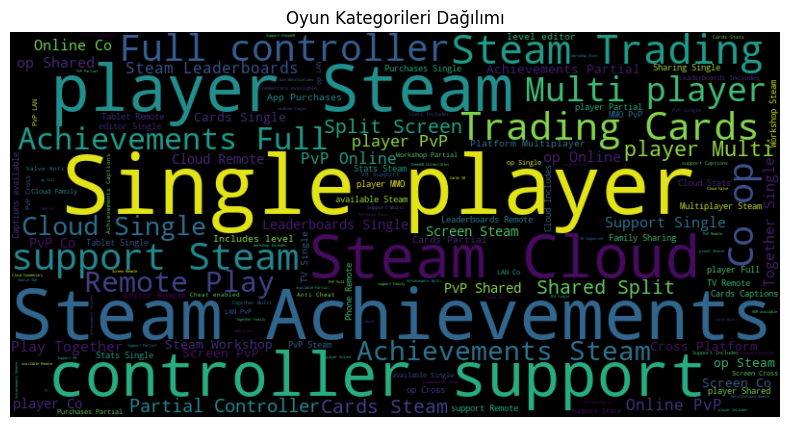

In [51]:
from wordcloud import WordCloud
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re

df["filtered_name"] = df["name"].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

all_categories = " ".join([" ".join(categories) for categories in df["categories"]])

wordcloud = WordCloud(width=800, height=400, background_color="black").generate(all_categories)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Oyun Kategorileri Dağılımı")
plt.show()

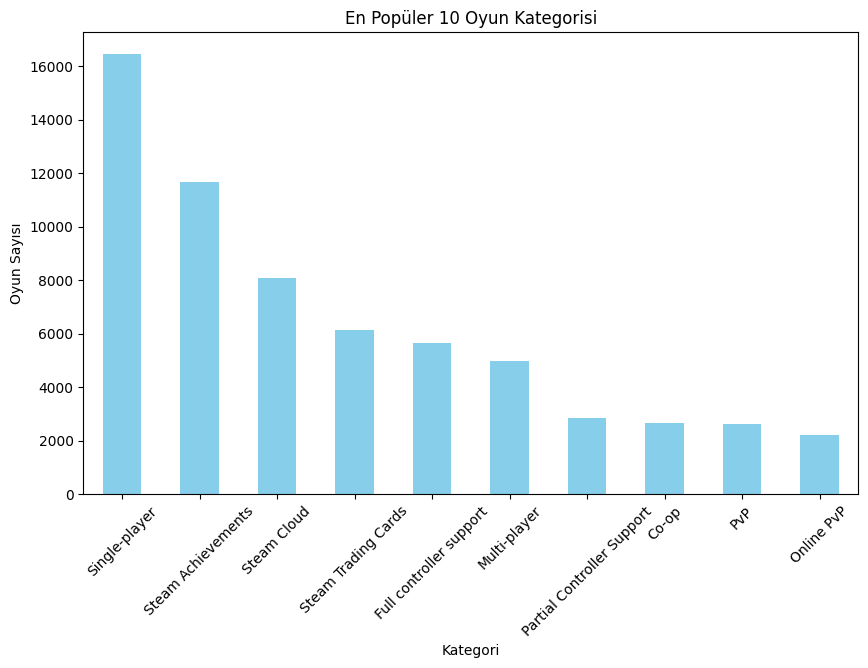

In [53]:
category_counts = pd.Series([cat for sublist in df["categories"] for cat in sublist]).value_counts()

plt.figure(figsize=(10,6))
category_counts[:10].plot(kind='bar', color='skyblue')
plt.title("En Popüler 10 Oyun Kategorisi")
plt.xlabel("Kategori")
plt.ylabel("Oyun Sayısı")
plt.xticks(rotation=45)
plt.show()

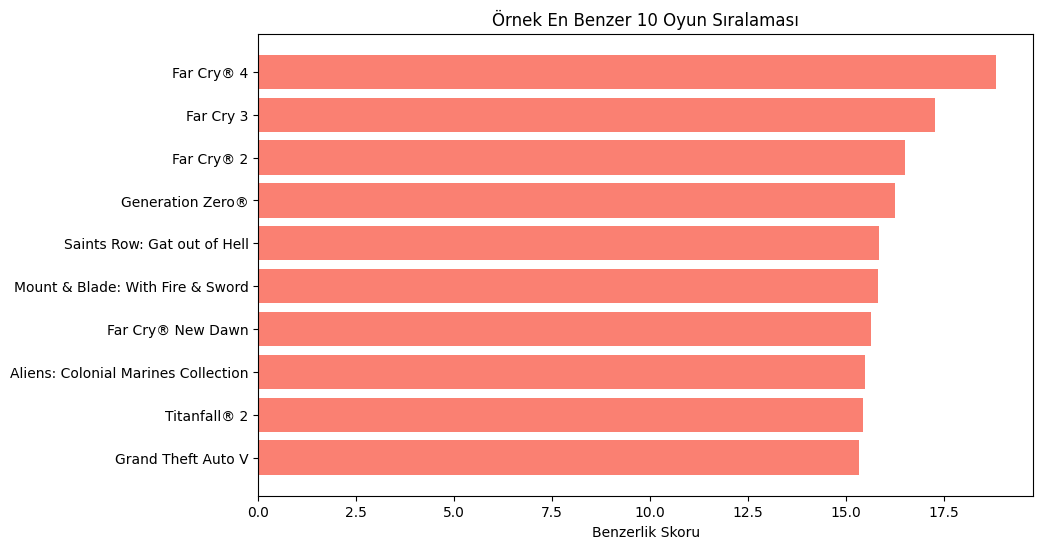

In [54]:
game_index = 0  
similar_games = final_similarity[15]
top_similar_indices = np.argsort(similar_games)[::-1][1:11]

similar_game_names = df.iloc[top_similar_indices]["name"].values
similar_game_scores = similar_games[top_similar_indices]

plt.figure(figsize=(10,6))
plt.barh(similar_game_names[::-1], similar_game_scores[::-1], color='salmon')
plt.xlabel("Benzerlik Skoru")
plt.title(f"Örnek En Benzer 10 Oyun Sıralaması")
plt.show()


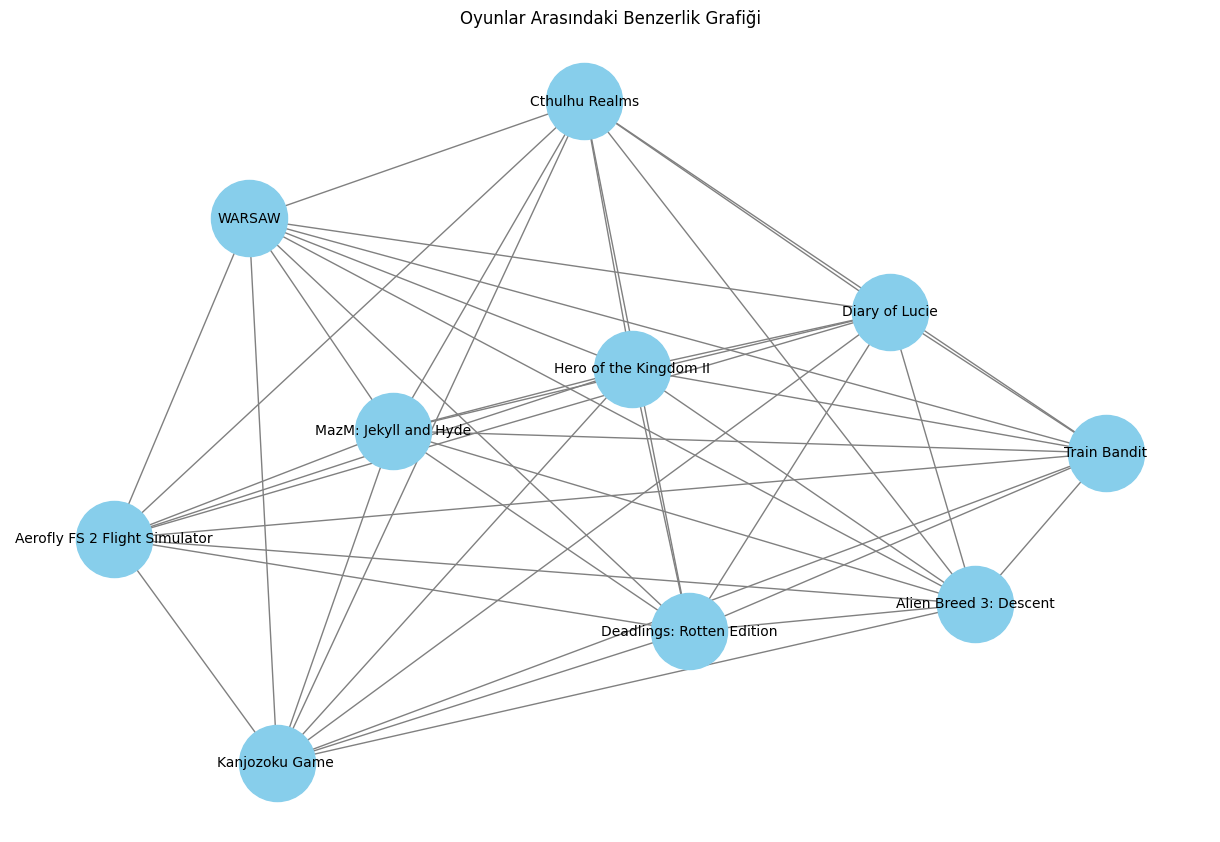

In [58]:
import networkx as nx
top_n_games = 10
similarity_subset = final_similarity[:top_n_games, :top_n_games]

G = nx.Graph()

game_names = df["filtered_name"].iloc[:top_n_games].tolist() 
threshold = 0.8
for i in range(top_n_games):
    for j in range(i+1, top_n_games):
        if similarity_subset[i, j] > threshold:
            G.add_edge(game_names[i], game_names[j], weight=similarity_subset[i, j])


plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, seed=42)  
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", edge_color="gray", font_size=10)
plt.title("Oyunlar Arasındaki Benzerlik Grafiği")
plt.show()

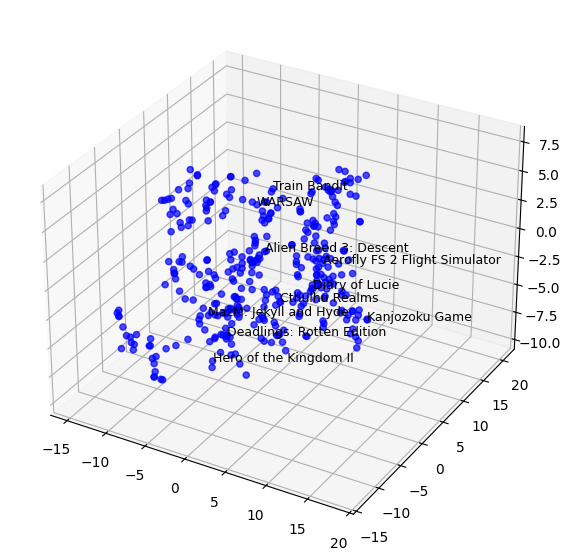

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=10, random_state=42) 
reduced_vectors_3d = tsne.fit_transform(basic_feature_matrix[:350])

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_vectors_3d[:, 0], reduced_vectors_3d[:, 1], reduced_vectors_3d[:, 2], alpha=0.7, c="blue")

for i, name in enumerate(df["filtered_name"][:10]):  
    ax.text(reduced_vectors_3d[i, 0], reduced_vectors_3d[i, 1], reduced_vectors_3d[i, 2], name, fontsize=9)

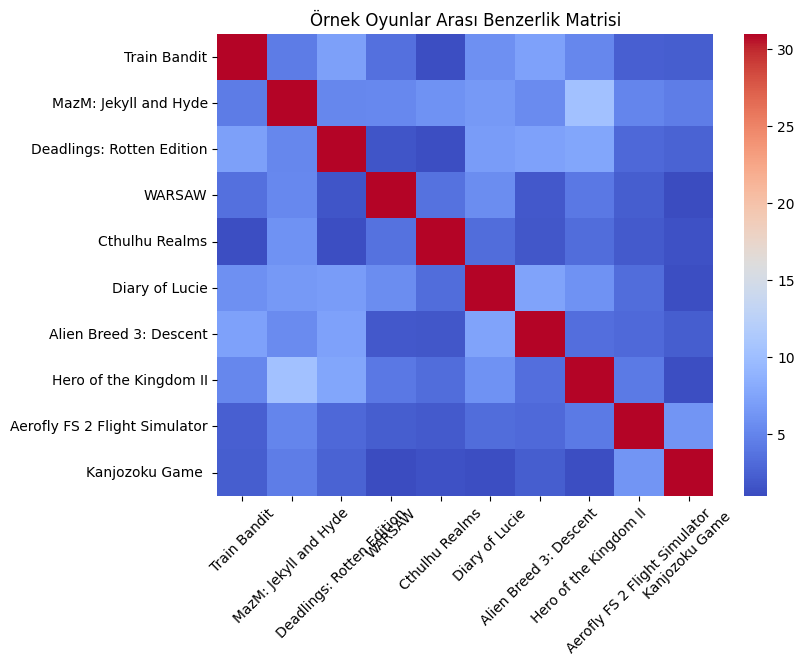

In [74]:
# Heatmap için oyun isimlerini al
game_names = df["filtered_name"].tolist()[:10]  

plt.figure(figsize=(8,6))
sns.heatmap(final_similarity[:10, :10], cmap="coolwarm", annot=False, xticklabels=game_names, yticklabels=game_names)
plt.xticks(rotation=45)  
plt.yticks(rotation=0)  
plt.title("Örnek Oyunlar Arası Benzerlik Matrisi")
plt.show()


Bu projede, Steam oyunları için **içerik tabanlı bir öneri sistemi geliştirilmiştir**.  
Kullanıcının sahip olduğu veya ilgi duyduğu oyunlara dayanarak **benzer oyunları öneren bir model** oluşturulmuştur.